### <center>Escolhendo o modelo de <strong>previsão</strong></center>

Importações

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.decomposition import PCA

Carregando os dados

In [63]:
path = 'excel/viajou-tratado copy.xlsx'
df = pd.read_excel(path)

Separando dados em características e alvo

In [64]:
X = df.drop(columns=['probabilidade_recomendar'])
y = df['probabilidade_recomendar']

Transformando em dados númericos

In [65]:
label_encoders = {}
for column in X.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    X[column] = label_encoders[column].fit_transform(X[column])


Substituindo os valores 1 e 2 por 0, e 3 e 4 por 1

In [66]:
y = y.replace({1: 0, 2: 0, 3: 1, 4: 1})

Separando em treino e teste

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Sem balanceamento

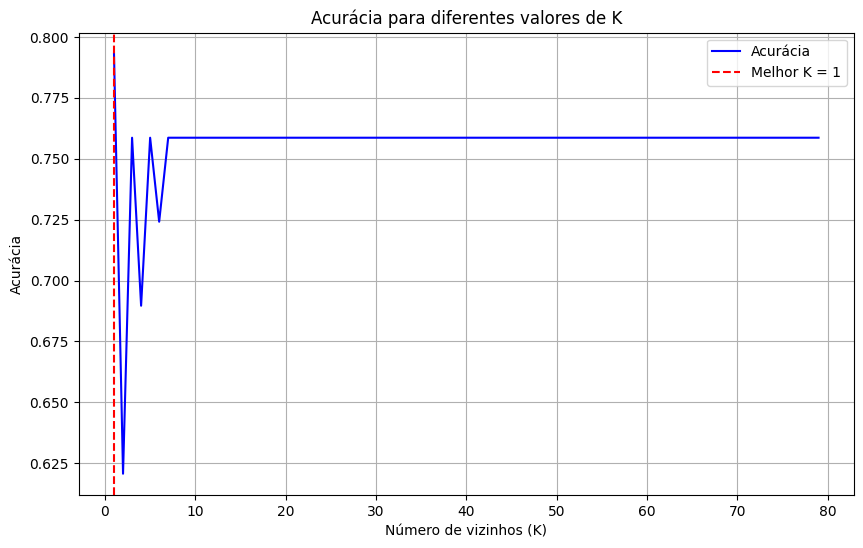

In [120]:
acuracias = {}

for i in range(1, 80):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    y_pred_knn = knn.predict(X_test)
    accuracy_knn = accuracy_score(y_test, y_pred_knn)
    acuracias[i] = accuracy_knn
    
melhor_k = max(acuracias, key=acuracias.get)

plt.figure(figsize=(10, 6))
plt.plot(list(acuracias.keys()), list(acuracias.values()), color='b', label='Acurácia')
plt.axvline(x=melhor_k, color='r', linestyle='--', label=f'Melhor K = {melhor_k}')
plt.title('Acurácia para diferentes valores de K')
plt.xlabel('Número de vizinhos (K)')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)
plt.show()

Dicionário de modelos para experimentar

In [121]:
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB()
}

##  Sem hiperparâmetros

In [122]:
model_results_without_hiper = {}

In [123]:
for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    
    report_dict = classification_report(y_test, y_pred, output_dict=True)
    
    report_df = pd.DataFrame(report_dict).transpose()
    
    model_results_without_hiper[model_name] = {
        'accuracy': accuracy,
        'report_df': report_df,  
        'best_params': 'N/A'
    }


Training Decision Tree...
Training K-Nearest Neighbors...
Training Naive Bayes...


C:\Users\gabrielioliveira-ieg\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gabrielioliveira-ieg\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gabrielioliveira-ieg\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

In [ ]:
model_results_without_hiper


              precision    recall  f1-score    support
0              0.000000  0.000000  0.000000   7.000000
1              0.758621  1.000000  0.862745  22.000000
accuracy       0.758621  0.758621  0.758621   0.758621
macro avg      0.379310  0.500000  0.431373  29.000000
weighted avg   0.575505  0.758621  0.654496  29.000000


In [73]:
results_df_without = pd.DataFrame(model_results_without_hiper).T
results_df_without


,accuracy,report_df,best_params
Decision Tree,0.62069,precision recall f1-score ...,N/A
K-Nearest Neighbors,0.758621,precision recall f1-score ...,N/A
Naive Bayes,0.793103,precision recall f1-score ...,N/A


## Modelos com hiperparâmetros

Configurações de hiperparâmetros para cada modelo

In [126]:
param_grid = {
    'Decision Tree': {
        'criterion': ['gini', 'entropy'],
        'splitter': ['best', 'random'],
        'max_depth': [2, 4, 6, 8, 10, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 5, 10],
        'max_features': [None, 'sqrt', 'log2']
    },
    'K-Nearest Neighbors': {
        'n_neighbors': [melhor_k],
        'weights': ['uniform', 'distance']
    },
    'Naive Bayes': {}  # Naive Bayes não possui hiperparâmetros
}

Dicionário para armazenar os melhores resultados após ajuste de hiperparâmetros

In [127]:
model_results = {}

Ajustar os hiperparâmetros para cada modelo, incluindo Naive Bayes

In [118]:
for model_name, model in models.items():
    if model_name == 'Naive Bayes':
        # Para o Naive Bayes, não usamos GridSearchCV porque não há hiperparâmetros
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        model_results[model_name] = {'accuracy': accuracy, 'report': report, 'best_params': 'N/A'}
    else:
        print(f"Tuning {model_name}...")
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid[model_name], 
                                   scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        
        # Fazer previsões com o melhor modelo
        y_pred = best_model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        
        # Armazenar os resultados do melhor modelo
        model_results[model_name] = {'accuracy': accuracy, 'report': report, 
                                                'best_params': grid_search.best_params_}

Tuning Decision Tree...
Fitting 5 folds for each of 864 candidates, totalling 4320 fits
Tuning K-Nearest Neighbors...
Fitting 5 folds for each of 2 candidates, totalling 10 fits


Exibindo os resultados

In [77]:
results_df = pd.DataFrame(model_results).T
results_df

,accuracy,report,best_params
Decision Tree,0.655172,precision recall f1-score ...,"{'criterion': 'gini', 'max_depth': 4, 'max_fea..."
K-Nearest Neighbors,0.793103,precision recall f1-score ...,"{'n_neighbors': 1, 'weights': 'uniform'}"
Naive Bayes,0.793103,precision recall f1-score ...,N/A


# Aplicando balanceamento de Classe

Aplicando SMOTE para balancear as classes

In [137]:
smote = SMOTE(random_state=42, k_neighbors=melhor_k) # Aplicando o melhor k diretamente no smote
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
print(y_resampled)

0      1
1      1
2      1
3      0
4      1
      ..
121    0
122    0
123    0
124    0
125    0
Name: probabilidade_recomendar, Length: 126, dtype: int64


Dicionário para armazenar os melhores resultados após ajuste de hiperparâmetros

In [106]:
model_results_with_smote = {}

Ajustar os hiperparâmetros para cada modelo, incluindo Naive Bayes

In [128]:
for model_name, model in models.items():
    if model_name == 'Naive Bayes':
        # Para o Naive Bayes, não usamos GridSearchCV porque não há hiperparâmetros
        model.fit(X_resampled, y_resampled)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        model_results_with_smote[model_name] = {'accuracy': accuracy, 'report': report, 'best_params': 'N/A'}
    else:
        print(f"Tuning {model_name}...")
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid[model_name], 
                                   scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
        grid_search.fit(X_resampled, y_resampled)
        best_model = grid_search.best_estimator_
        
        # Fazer previsões com o melhor modelo
        y_pred = best_model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        
        # Armazenar os resultados do melhor modelo
        model_results_with_smote[model_name] = {'accuracy': accuracy, 'report': report, 
                                                'best_params': grid_search.best_params_}


Tuning Decision Tree...
Fitting 5 folds for each of 864 candidates, totalling 4320 fits
Tuning K-Nearest Neighbors...
Fitting 5 folds for each of 2 candidates, totalling 10 fits


c:\Python312\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Exibindo os resultados com SMOTE

In [129]:
print(model_results_with_smote['K-Nearest Neighbors']['report'])

              precision    recall  f1-score   support

           0       0.57      0.57      0.57         7
           1       0.86      0.86      0.86        22

    accuracy                           0.79        29
   macro avg       0.72      0.72      0.72        29
weighted avg       0.79      0.79      0.79        29



In [130]:
results_df_smote = pd.DataFrame(model_results_with_smote).T

In [134]:
results_df

,accuracy,report,best_params
Decision Tree,0.655172,precision recall f1-score ...,"{'criterion': 'gini', 'max_depth': 4, 'max_fea..."
K-Nearest Neighbors,0.793103,precision recall f1-score ...,"{'n_neighbors': 1, 'weights': 'uniform'}"
Naive Bayes,0.793103,precision recall f1-score ...,N/A


# PCA

In [138]:
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

# Definir os modelos com os melhores parâmetros do KNN e estruturas básicas para os outros modelos
models_with_params = {
    'KNN': KNeighborsClassifier(**model_results_with_smote['K-Nearest Neighbors']['best_params']),
    'Decision Tree': DecisionTreeClassifier(**model_results_with_smote['Decision Tree']['best_params']),
    'Naive Bayes': GaussianNB()  # Naive Bayes não tem hiperparâmetros ajustáveis
}

# Aplicar PCA para cada modelo com diferentes números de componentes principais
for model_name, model in models_with_params.items():
    print(f"\nAplicando PCA para o modelo: {model_name}\n")
    
    for n in range(1, 17):
        print(f"Aplicando PCA com {n} componentes para o modelo {model_name}...")
        
        # Aplicar PCA com n componentes
        pca = PCA(n_components=n)
        x_train_pca = pca.fit_transform(X_resampled)
        x_test_pca = pca.transform(X_test)
        
        # Treinar o modelo com o SMOTE aplicado e dados transformados pelo PCA
        model.fit(x_train_pca, y_resampled)
        
        # Fazer previsões
        y_pred = model.predict(x_test_pca)
        
        # Exibir o relatório de classificação para o modelo atual com PCA e o número atual de componentes
        print(f'N Componentes: {n}')
        print(classification_report(y_test, y_pred))


Aplicando PCA para o modelo: KNN

Aplicando PCA com 1 componentes para o modelo KNN...
N Componentes: 1
              precision    recall  f1-score   support

           0       0.10      0.14      0.12         7
           1       0.68      0.59      0.63        22

    accuracy                           0.48        29
   macro avg       0.39      0.37      0.38        29
weighted avg       0.54      0.48      0.51        29

Aplicando PCA com 2 componentes para o modelo KNN...
N Componentes: 2
              precision    recall  f1-score   support

           0       0.09      0.14      0.11         7
           1       0.67      0.55      0.60        22

    accuracy                           0.45        29
   macro avg       0.38      0.34      0.36        29
weighted avg       0.53      0.45      0.48        29

Aplicando PCA com 3 componentes para o modelo KNN...
N Componentes: 3
              precision    recall  f1-score   support

           0       0.12      0.14      0.13   

In [ ]:
excel = 'excel/resultados.xlsx'

with pd.ExcelWriter(excel, engine='xlsxwriter') as writer:
    results_df_without.to_excel(writer, sheet_name='Sem Hiperparametros', index=True)
    results_df.to_excel(writer, sheet_name='Sem SMOTE', index=True)
    results_df_smote.to_excel(writer, sheet_name='Com SMOTE', index=True)

print(f"DataFrames exportados com sucesso para {excel}")


DataFrames exportados com sucesso para excel/resultados.xlsx
